Saving classifier_mnist.h5 to classifier_mnist (2).h5
['dataset/horse', 'dataset/car', 'dataset/cat']
[INFO] reading data and preparation...
[INFO] prepared data is saved.
['horse', 'horse', 'car', 'car', 'cat', 'cat', 'cat']
labels/numbers are:
 car            /         2
 cat            /         3
 horse          /         2

(7, 28, 28, 1)
[INFO] input/output shapes: (7, 28, 28, 1, 1)/(7, 3)
 THE OUTPUT OF THE FIRST GENERATOR: 
iteration: 0
iteration: 1
iteration: 2


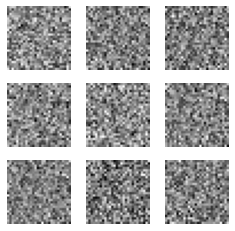

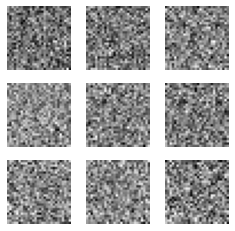

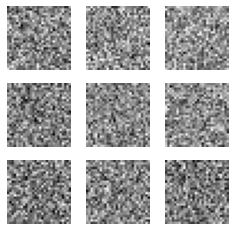

In [ ]:
import os
import cv2
import keras
import argparse
import numpy as np
import pandas as pd
from glob import glob
from cv2 import imread
import tensorflow as tf
from keras import layers
import tensorflow_hub as hub
from google.colab import files
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.optimizers import Adam,SGD,RMSprop
from keras.layers.advanced_activations import LeakyReLU , ReLU
from keras.layers import Dense,Flatten,Reshape,GaussianNoise

# Get information from user
parser = argparse.ArgumentParser(description='MODEL ACTIVITY ANALYZER.')
parser.add_argument('--dataset', default='./dataset', type=str, help='path to dataset')
parser.add_argument('--saved_model', default='model file name', type=str, help='saved_model file name')
parser.add_argument('--lx', default=128, type=int, help='image length')
parser.add_argument('--ly', default=128, type=int, help='image width')
parser.add_argument('--n_sample', default=4, type=int, help='number of sample')
parser.add_argument('--channels', default=3, type=int, help='number of channels')
parser.add_argument('--dpi', default=200, type=int, help='image dpi')
parser.add_argument('--restart', action="store_true")
parser.add_argument('--nclass', default=200, type=int, help='number of classes')

args = parser.parse_args()
data_path = args.dataset
saved_model = args.saved_model
img_rows,img_cols = args.lx,args.ly
n_sample = args.n_sample
restart = args.restart
dpi = args.dpi
channels = args.channels
nclass = args.nclass
num_iteration = 3
batch_size = 128
zdim=100
img_shape = (img_rows,img_cols,channels)


'''# upload your saved model(for colab)
saved_model = files.upload()

# preparing saved_model
saved_model = saved_model.keys()
saved_model = list(saved_model)[0]'''

# Biulding GAN
def build_gan(gen,dis):
    model = Sequential()
    model.add(gen)
    model.add(dis)
    return model

# Building Discriminator
dis_v = tf.keras.models.load_model(saved_model, custom_objects={'KerasLayer': hub.KerasLayer})
dis_v.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
losses=[]
accuracies=[]
iteration_checks=[]


def train(iterations,batch_size):
    data_path = 'dataset'
    paths = glob(data_path+'/*')
    print(paths)
    #labels = [i.split('/')[-1] for i in paths]

    dataset_name = 'dataset'

    print("[INFO] reading data and preparation...")
    if not os.path.isfile(dataset_name) or restart:
        x = []
        labels = []
        for path in paths:
            files = glob(path+'/*')
            for fil in files:
                    img = imread(fil)
                    img = np.resize(img,(img_rows,img_cols))
                    #img = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
                    if img.ndim==3:
                        img = np.mean(img,axis=-1)
                    x.append(img)
                    labels.append(fil.split('/')[-2])

        print("[INFO] prepared data is saved.")
        np.savez('data_set',x=x,labels=labels)
    else:
        data = np.load('data_set.npz')
        x = data['x']
        labels = data['labels']

    print(labels)

    class_labels, nums = np.unique(labels,return_counts=True)
    n_calss = len(class_labels)
    print('labels/numbers are:\n',*['{:15s}/{:10d}\n'.format(i,j) for i,j in zip(class_labels,nums)])

    dummy = {j: i for i,j in enumerate(labels)}
    int_map = {}
    lbl_map = {}
    for j,(i,_) in enumerate(dummy.items()):
      int_map[i] = j
      lbl_map[j] = i

    vec = [int_map[word] for word in labels]
    x = np.array(x)
    x = x/np.max(x)
    x = np.expand_dims(x,axis=3)
    print('[INFO] input shapes: {}'.format(x.shape))
    vec = np.array(vec)
    y = keras.utils.to_categorical(vec, num_classes=None, dtype='float32')
    n_data,lx0,ly0,channel = x.shape
    x = x[:,:,:,None]

    # x = np.stack(3*[x],axis=-1)

    real = np.ones((batch_size,nclass))
    fake = np.zeros((batch_size, nclass))
    bold_start = '\033[1m'
    bold_end   = '\033[0m' 
    print(bold_start,'THE OUTPUT OF THE FIRST GENERATOR:',bold_end)
    for iteration in range(iterations):

        print('iteration:',iteration)

        ids = np.random.randint(0,x.shape[0],batch_size)
        imgs = x[ids]

        z=np.random.normal(0,1,(batch_size,100))
        gen_imgs = gen_v.predict(z)

        z = np.random.normal(0, 1, (batch_size, 100))
        gloss = gan_v.train_on_batch(z,real)

        show_images(gen_v)


# plot the network output
def show_images(gen):
    z = np.random.normal(0, 1, (16, 100))
    gen_imgs = gen.predict(z)
    gen_imgs = 0.5*gen_imgs + 0.5

    fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)

    cnt=0
    for i in range(3):
        for j in range(3):
            axs[i, j].imshow(gen_imgs[cnt].reshape((28,28)),cmap='gray')
            axs[i, j].axis('off')
            cnt+=1

    fig.show()
  

# Generator1
def build_gen1(img_shape,zdim):
    model = tf.keras.Sequential([layers.Dense(28,bias_regularizer=regularizers.l2(1e-4),input_shape=(zdim,)),
                               layers.LeakyReLU(alpha=0.01),
                               layers.Dense(28*28*1,activation='tanh',bias_regularizer=regularizers.l2(1e-4)),
                               layers.Flatten(),
                               layers.Reshape(img_shape)
                               ])
    return model

# Biulding GAN_1
gen_v = build_gen1(img_shape,zdim)
dis_v.trainable=False
gan_v = build_gan(gen_v,dis_v)
gan_v.compile(loss='binary_crossentropy',optimizer=Adam())


train(num_iteration,batch_size)